# Biweekly Report 1 - Housing Sale Price Prediction By Linear Regression

From previous classes we learned linear models, epecially linear regression, whose loss function is baiscally the sum of squared errors (SSE). Here I am going to use linear regression models (including Ridge and Lasso) for housing sale price prediction. The dataset I use is  the Ames Housing dataset provided by kaggle: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

## Steps:
· Early Analysis  
· Data Preprocessing  
· Linear Regression Prediction  
· Analysis  

## Data Preprocessing

Firstly, let's import modules we need and read the data files. 

In [2]:
import warnings
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'png' #retina
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
from scipy.stats import skew,norm
from scipy.stats.stats import pearsonr

In [3]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

We can first take a look at the numbers of columns and rows of data. 

In [4]:
print('Train Data: \n')
print("Number of columns: "+ str(train.shape[1]))
print("Number of rows: "+ str(train.shape[0]))
print('\nTest Data: \n')
print("Number of columns: "+ str(test.shape[1]))
print("Number of rows: "+ str(test.shape[0]))

Train Data: 

Number of columns: 80
Number of rows: 1460

Test Data: 

Number of columns: 79
Number of rows: 1459


Then, we get a statistics summary of SalePrize, which is the target that we are going to predict. 

In [6]:
#descriptive statistics summary
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

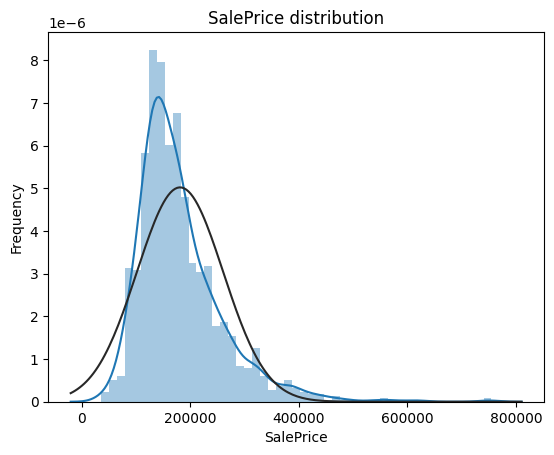

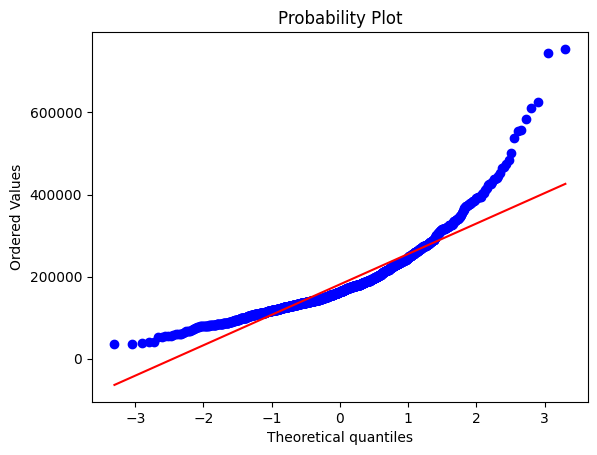

In [7]:
# Kernel Density Plot
sns.distplot(train.SalePrice,fit=norm);
plt.ylabel('Frequency')
plt.title('SalePrice distribution');
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice']);
# QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

According to the plots above, the target variable is right skewed(positive skewness) and show peakedness. As linear models fits better on normally distributed data, I use log transformation here  to normalize the data, i.e. 

    Transform the skewed numeric features by taking log(feature + 1) to make features more normal. 

It is a commonly used statisical method to address skewed data.   
Later we will cover Box-Cox transformation, which is also a useful way to normalize this kind of data. 
    
##### Transformation is Performed after univariate analysis.    

### Relation Exploration for Several Numerical Variables

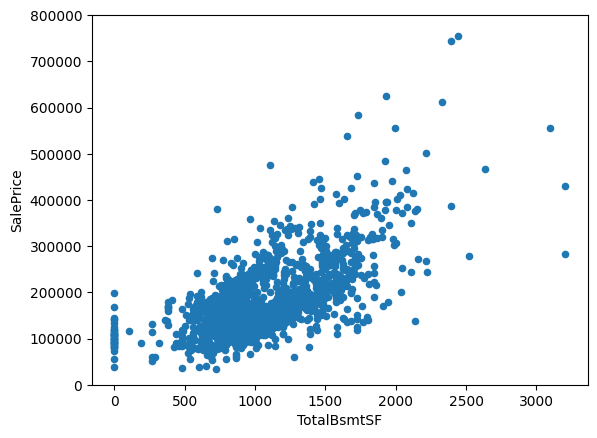

In [11]:
#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

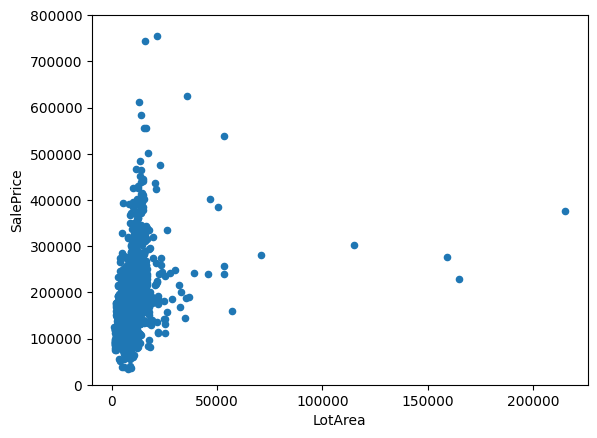

In [10]:
#scatter plot LotArea/saleprice
var = 'LotArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

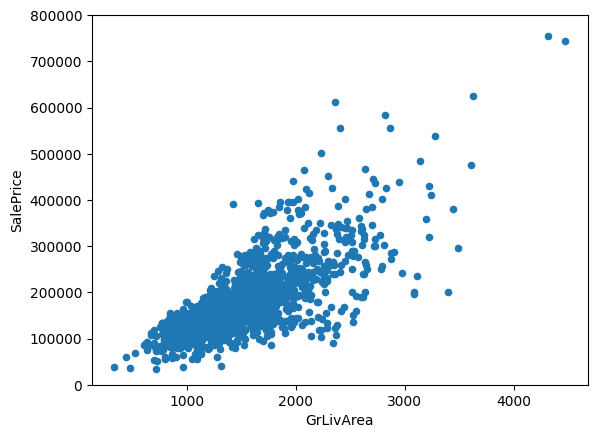

In [9]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [8]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

'TotalBsmtSF','LotArea' and 'GrLivArea' seem to be linearly related with 'SalePrice'. Both relationships are positive, which means that as one variable increases, the other also increases. In the case of 'TotalBsmtSF' and 'LotArea' we can see that the slope of the linear relationship are particularly high.

## Relation Exploration for Categorical Features

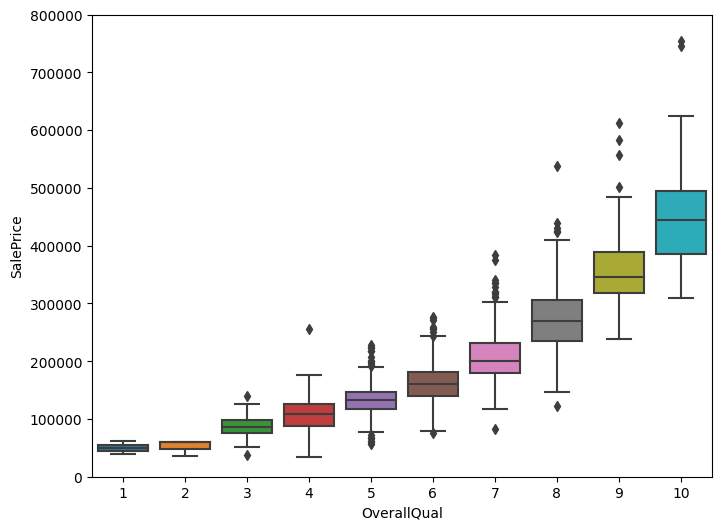

In [12]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

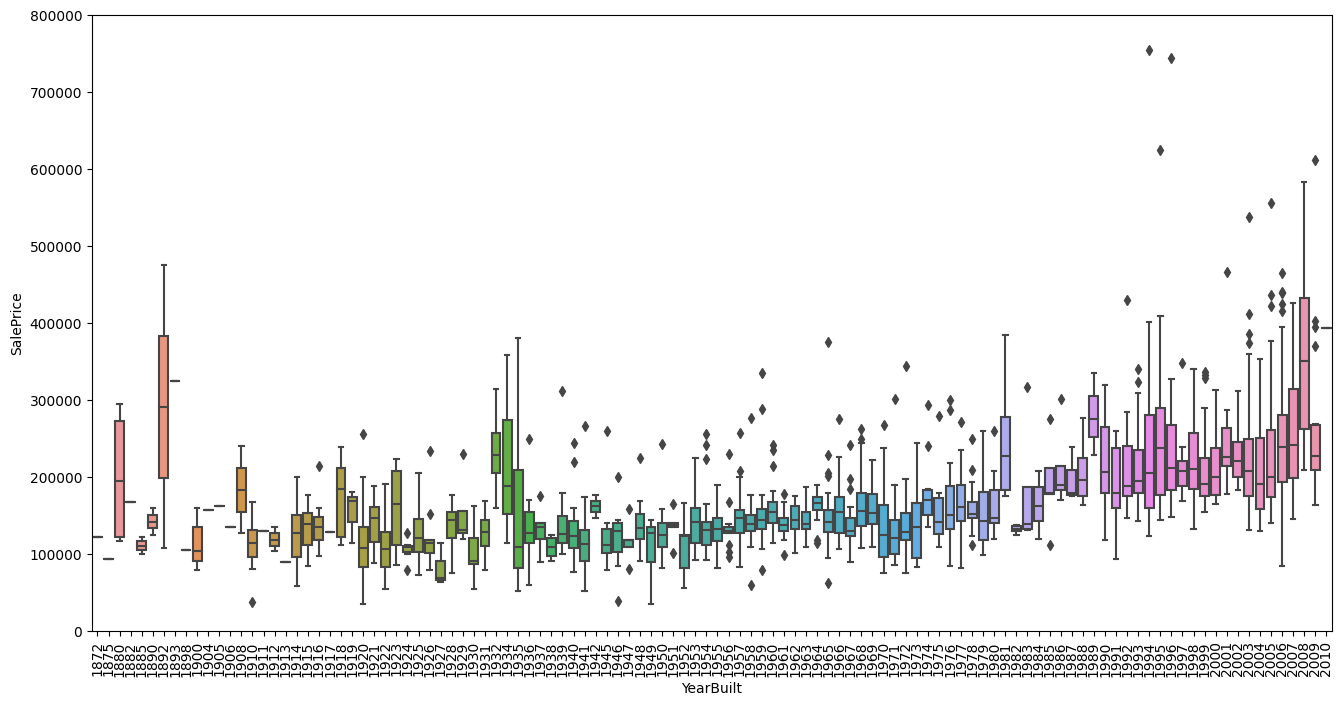

In [13]:
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

Note: I don't know if 'SalePrice' is in constant prices. Constant prices try to remove the effect of inflation. If 'SalePrice' is not in constant prices, it should be, so than prices are comparable over the years.

'OverallQual' and 'YearBuilt' also seem to be related with 'SalePrice'. The relationship seems to be stronger in the case of 'OverallQual', where the box plot shows how sales prices increase with the overall quality.

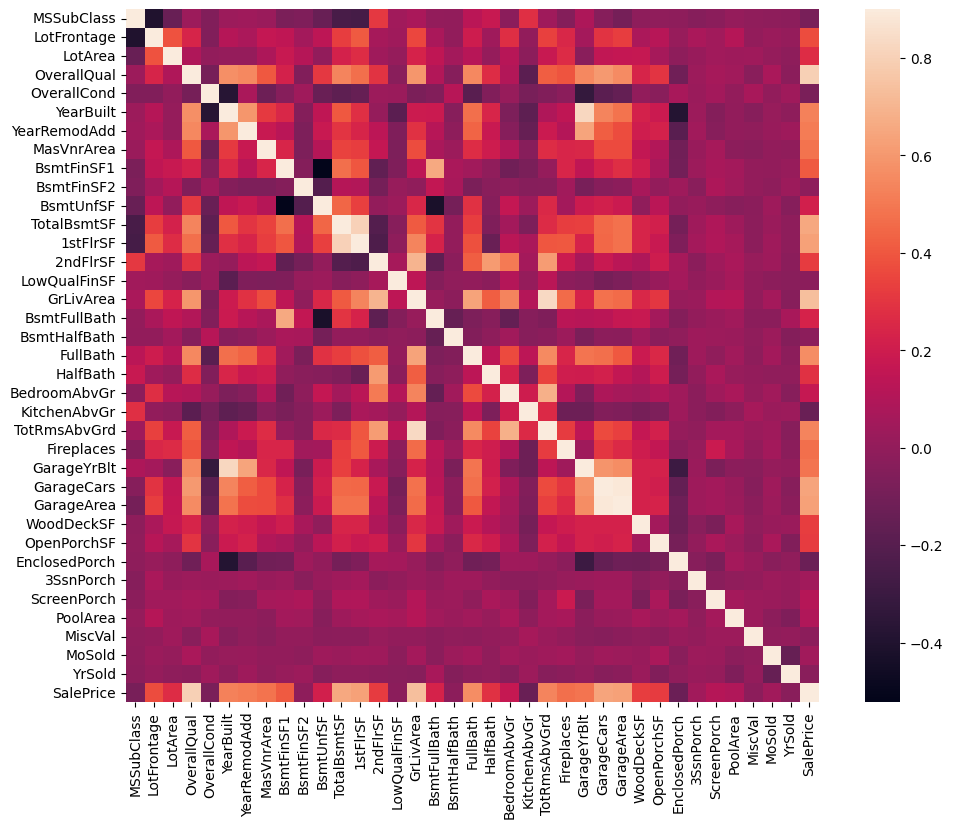

In [14]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.9, square=True);

In [15]:
#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.881296
Kurtosis: 6.523067


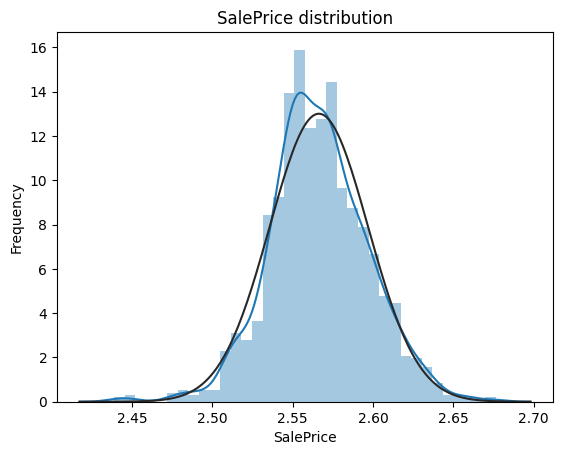

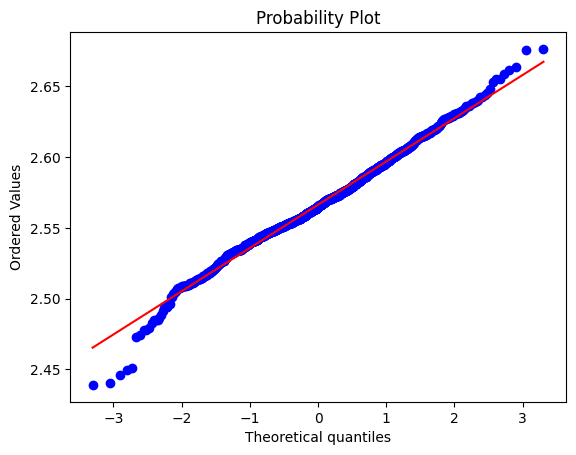

In [19]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

# Kernel Density Plot
sns.distplot(train.SalePrice,fit=norm);
plt.ylabel('Frequency')
plt.title('SalePrice distribution');
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice']);
# QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

Let's get a look at the first 5 rows of data. 

In [20]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,2.583824
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,2.573300
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,2.589054
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,2.553297
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,2.597433


In [21]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

print("all_data size is : {}".format(all_data.shape))
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

all_data size is : (2917, 79)


,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageQual,5.450806
GarageCond,5.450806
GarageYrBlt,5.450806


From the above table we can see that there are a lot of missing values in the data. We are going to complete them soon. 

## Imputing missing values

I fill the missing values in the data in this step. You can see how I do this thing respectively for different features in the code comments. Based on feature description provided, following features if has NA means it's absent("None"). 

In [22]:
for col in ('PoolQC','MiscFeature','GarageType','Alley','Fence','FireplaceQu','GarageFinish', 'GarageQual', 'GarageCond','MasVnrType','MSSubClass'):
    all_data[col] = all_data[col].fillna('None')

In [23]:
# Replacing missing data with 0 (Since No garage = no cars in such garage).
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
# missing values are likely zero for having no basement 
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
#     
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [24]:
# For below categorical basement-related features, NaN means that there is no basement.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [25]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [26]:
# Setting mode value for missing entries 

#MSZoning classification : 'RL' is common
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

# Functional : NA = typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")

# Electrical
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

# KitchenQual
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

# Exterior1st and Exterior2nd
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

#SaleType
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [27]:
#  Dropping as same value 'AllPub' for all records except 2 NA and 1 'NoSeWa'
all_data = all_data.drop(['Utilities'], axis=1)

In [28]:
# Transforming required numerical features to categorical

all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [29]:
#Label Encoding some categorical variables 
# for information in their ordering set

from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


In [30]:
# Adding Total surface area as 'TotalSF'= basement+firstflr+secondflr

all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [31]:
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False) #compute skewness
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(5)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080


#### Box Cox Transformation of (highly) skewed features
Now we Box-Coc transform skewed numerical features. The formula is: $$ Y = (Z^\lambda -1)*\lambda $$  
If a numeric variable has highly skewed, i.e. skewness > 0.75, we perform the transformation. I set $\lambda$ to be 0.15 here.   
Log transformation we mentioned above is actually a special case of Box-Cox transformation when $\lambda = 0$. I do not want to explain it in detail here because we can simply use functions in scipy packages. But feel free to contact me if you want to discuss on it. 

In [33]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform.".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform.


#### Adding dummy categorical features

Since the regression algorithms cannot process categorical variables, all the categorical variables are converted to numerical variables using get_dummies() function in the pandas library in python. 

In [34]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [35]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train= train.SalePrice.values
train = pd.DataFrame(all_data[:ntrain])
test = pd.DataFrame(all_data[ntrain:])

### Creating test and train set

### Regression Modeling

In [51]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error


For Cross-validation purpose we can use cross_val_score function of Sklearn. However this function has not a shuffle attribut, we add then one line of code on Alexandru function, in order to shuffle the dataset prior to cross-validation

In [63]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### Prediction: Implementing Regression Models
Let's try the models we have learned in class:   

    1. Ridge Regression
    2. Lasso Regression

In [64]:
#1
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
#2
Ridge = Ridge()


### Scores for above base models

In [65]:


score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(Ridge)
print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))





Lasso score: 0.0100 (0.0006)

Ridge: 0.0095 (0.0008)



## Stacking Models

#### Approach: Averaging Base Models


In [68]:
#Average Based models class

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   


    
# Averaged base models score

averaged_models = AveragingModels(models = (Ridge, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.0091 (0.0008)



In [69]:
# Defining rmsle evaluation function
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [70]:
#Final Training and Prediction

#StackedRegressor:

averaged_models.fit(train.values, y_train)
stacked_train_pred = averaged_models.predict(train.values)
stacked_pred = np.expm1(averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.008242148090297108


In [72]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred ))

RMSLE score on train data:
0.008242148090297108


In [73]:
# Ensembled Predictions:

ensemble = stacked_pred

In [74]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)